In [1]:
import autograd.numpy as np
from autograd.scipy.stats import norm
from autograd import grad, hessian

import matplotlib.pyplot as plt

from minimize import *
from helpers import *

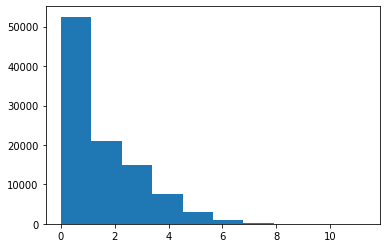

1.3970989533116491
1.3955931148026122
1.3955931148026122


In [2]:
num_samples = int(1e5)
f0 = 1.
loc = 0.
scale = 2.

f = np.random.normal(loc=loc, scale=scale, size=(num_samples,))
improvement = f0 - f
improvement = np.max([improvement, np.zeros_like(improvement)], axis=0)

plt.hist(improvement)
plt.show()

z = (f0 - loc) /scale
mean_improvement = np.mean(improvement)
expected_improvement = scale * (z * norm.cdf(z) + norm.pdf(z))
expected_improvement_ = (f0 - loc) * norm.cdf((f0 - loc) / scale) + scale * norm.pdf((f0 - loc) / scale)
print(mean_improvement)
print(expected_improvement)
print(expected_improvement_)

# Approximate log EI



In [3]:
log_ei = lambda z, scale : np.log(scale * (z * norm.cdf(z) + norm.pdf(z)))

In [4]:
def approx_log_ei(z, scale):
    
    cdf_term = - 0.5 * np.log(2 * np.pi) - 0.5 * z ** 2
    hopital_term = - np.log(z ** 2 - 1)
    
    return cdf_term + hopital_term

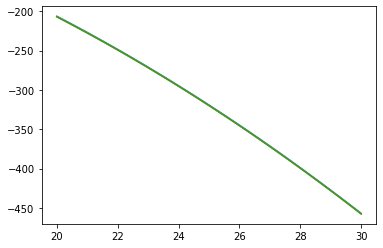

In [5]:
f0 = 1.
scale = 2.
zs = np.linspace(-20., -30, 100)

exact = [log_ei(z, scale) for z in zs]
approx = [approx_log_ei(z, scale) for z in zs]
approx_ = [log_expected_improvement(f0=f0, m=(f0 - scale * z), v=scale ** 2) for z in zs]

plt.plot(-zs, exact)
plt.plot(-zs, approx)
plt.plot(-zs, approx_)
plt.show()

# Fitting data and computing the log EI

In [6]:
def sample_sine_data(t, omega, R):
    
    noise = R[0, 0]
    
    x = np.array([np.cos(omega * t) - 1e-1 * t,
                  - omega * np.sin(omega * t) - 1e-1,
                  - omega ** 2 * np.cos(omega * t)]).T
    
    y = x[:, :2].copy()
    y[:, 0] = y[:, 0] + noise ** 0.5 * np.random.normal(size=y[:, 0].shape)
    
    return x, y

In [7]:
def f(t, t_data, ms, Vs, iVC):
    
    # Objective value to improve on
    f0 = np.min(ms[:, 0])
    
    m, v = post_pred(t, t_data, ms, Vs, iVC)
    
    # Log expected improvement at time t
    log_ei = log_expected_improvement(f0=f0, m=m[0], v=v[0, 0])

    return - log_ei

df = grad(f, argnum=0)
ddf = hessian(f, argnum=0)

def objective(t, t_data, ms, Vs, iVC):
    
    f_ = f(t, t_data, ms, Vs, iVC)
    df_ = df(t, t_data, ms, Vs, iVC)
    ddf_ = float(ddf(t, t_data, ms, Vs, iVC))
    
    return f_, df_, ddf_

In [8]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, -1, -2])
S0 = 1e-2 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(2)

# Define matrices A, Q (dynamics)
num_points = 2
t = np.linspace(0, 10, num_points) + 0. * np.cumsum(np.random.rand(num_points))
omega = 1.5

# Overal variance parameter θ and log noise to signal ratio
theta2 = 1.
log_nsr = -2.

# Define matrices C, R (data emission)
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_nsr) / theta2, 0],
              [0,                        0]])

# Sample points
x, y = sample_sine_data(t=t, omega=omega, R=R)

# Newton budget
budget = 5

# WP constants
c1 = 0.05
c2 = 0.8

def num_points_to_idx(num_points):
    
    idx_list = []
    idx = 0
    q = 4
    
    for i in range(num_points):
        
        idx_list.append(idx)
        idx = idx + 2
        
        if idx % q == 0:
            
            q = q * 2
            idx = 0
        
    return idx_list
        

for idx in num_points_to_idx(10):
    
    mf, Vf, ms, Vs, iVC, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)
    
    tmin = None
    tmax = None
    t0 = None
    
    if idx == y.shape[0] - 1:
        
        tmin = t[idx]
        tmax = t[idx] + 2e-1 * (t[-1] - t[0])
        
    else:
        tmin = t[idx]
        tmax = t[idx+1]
        
    t0 = (tmax + tmin) / 2
    
    t_opt, f_opt = newton(objective=objective,
                          budget=budget,
                          t0=t0,
                          tmin=tmin,
                          tmax=tmax,
                          t_data=t,
                          ms=ms,
                          Vs=Vs,
                          iVC=iVC)
    
    x_new, y_new = sample_sine_data(t=np.array([t_opt]), omega=omega, R=R)
    x_new, y_new = x_new[0], y_new[0]
    
    t = np.insert(t, idx + 1, t_opt)
    
    x = np.insert(x, idx + 1, x_new, axis=0)
    y = np.insert(y, idx + 1, y_new, axis=0)
    
# x, y = sample_sine_data(t=t, omega=omega, R=R)
mf, Vf, ms, Vs, iVC, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)

In [9]:
wp_probs = wolfe_powell(c1=c1, c2=c2, t=t, ms=ms, Vs=Vs, iVC=iVC)

In [10]:
t.shape, y.shape, log_nsr

((12,), (12, 2), -2.0)

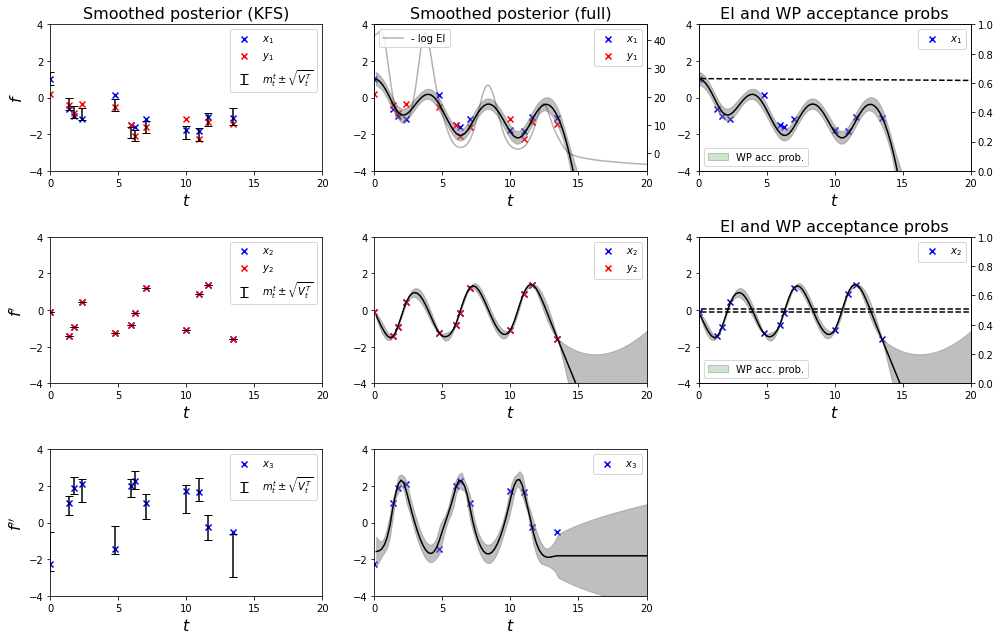

In [11]:
plt.figure(figsize=(14, 9))

t_, m_, v_ = line_post_pred(t, ms, Vs, iVC)

for i in range(3):
    
    # =========================================================================
    # Plotting smoothed posterior
    # =========================================================================
    
    plt.subplot(3, 3, 3 * i + 1)
    
    plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (KFS)', fontsize=16)
    
    plt.errorbar(x=t,
                 y=ms[:, i],
                 yerr=Vs[:, i, i] ** 0.5,
                 color='black',
                 zorder=2,
                 fmt="none",
                 label=r"$m_t^t \pm \sqrt{V_t^T}$",
                 capsize=4)
    
    plt.xticks(np.linspace(0, 20, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.xlim([0, 20])
    plt.ylim([-4, 4])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend(loc='upper right')
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)
    
    # =========================================================================
    # Plotting quintic spline posterior
    # =========================================================================

    plt.subplot(3, 3, 3 * i + 2)
    
    plt.plot(t_, m_[:, i], color='k')
    plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        pass
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (full)', fontsize=16)

    plt.fill_between(t_,
                     m_[:, i] - v_[:, i, i] ** 0.5,
                     m_[:, i] + v_[:, i, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.xticks(np.linspace(0, 20, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.xlim([0, 20])
    plt.ylim([-4, 4])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend(loc='upper right')
    
    if i == 0:
        ax2 = plt.gca().twinx()
        
        mf, Vf, ms, Vs, iVC, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)

        xlin = np.linspace(t[0] + 1e-2, 20 - 1e-2, 200)
        obj = [objective(t=t_, t_data=t, ms=ms, Vs=Vs, iVC=iVC)[0] for t_ in xlin]
        ax2.plot(xlin, obj, color='black', zorder=1, alpha=0.3, label='- log EI')
        
        plt.legend(loc='upper left')
    
    
    # =========================================================================
    # Plotting WP acceptance probabilities
    # =========================================================================

    if i < 2:
        
        plt.subplot(3, 3, 3 * i + 3)

        if i == 0:
            wp_line = ms[0, 0] + t_ * c1 * ms[0, 1]
            plt.plot(t_, wp_line, '--', color='k')
            
        else:
            wp_line1 = c2 * np.abs(ms[0, 1]) * np.ones_like(t_)
            wp_line2 = - c2 * np.abs(ms[0, 1]) * np.ones_like(t_)
            plt.plot(t_, wp_line1, '--', color='k')
            plt.plot(t_, wp_line2, '--', color='k')
        
        plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
        plt.title('EI and WP acceptance probs', fontsize=16)

        plt.plot(t_, m_[:, i], color='k')
        plt.fill_between(t_,
                         m_[:, i] - v_[:, i, i] ** 0.5,
                         m_[:, i] + v_[:, i, i] ** 0.5,
                         color='gray', alpha=0.5)

        plt.xticks(np.linspace(0, 20, 5))
        plt.yticks(np.linspace(-4, 4, 5))
        plt.ylim([-4, 4])

        plt.xlabel(r'$t$', fontsize=16)
        plt.legend(loc='upper right')

        ax2 = plt.gca().twinx()
        ax2.bar(t[1:], wp_probs, width=0.3, color='green', alpha=0.2, linewidth=1, edgecolor='black', label='WP acc. prob.')

        plt.legend(loc='lower left')
        plt.xlim([0, 20])
        plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# Run from here onwards

In [12]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, -1, -2])
S0 = 1e-2 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(2)

# Define matrices A, Q (dynamics)
num_points = 1
t = np.linspace(0, 10, num_points) + 0. * np.cumsum(np.random.rand(num_points))
t_guess = np.array([5.])
omega = 1.5

# Overal variance parameter θ and log noise to signal ratio
theta2 = 1.
log_nsr = -2.

# Define matrices C, R (data emission)
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_nsr) / theta2, 0],
              [0,                        0]])

# Sample points
x, y = sample_sine_data(t=t, omega=omega, R=R)

# Newton budget
budget = 5

# WP constants
c1 = 0.05
c2 = 0.8
wp_thresh = 0.95

data_objective = lambda t : sample_sine_data(t=np.reshape(t, (-1)), omega=omega, R=R)[1]

t, y, wp_probs, ms, Vs, iVC, post_probs = line_search(objective=data_objective,
                                                      c1=c1,
                                                      c2=c2,
                                                      wp_thresh=wp_thresh,
                                                      t0=t[0],
                                                      y0=y,
                                                      t_guess=t_guess)

x = sample_sine_data(t=t, omega=omega, R=0.*R)[0]

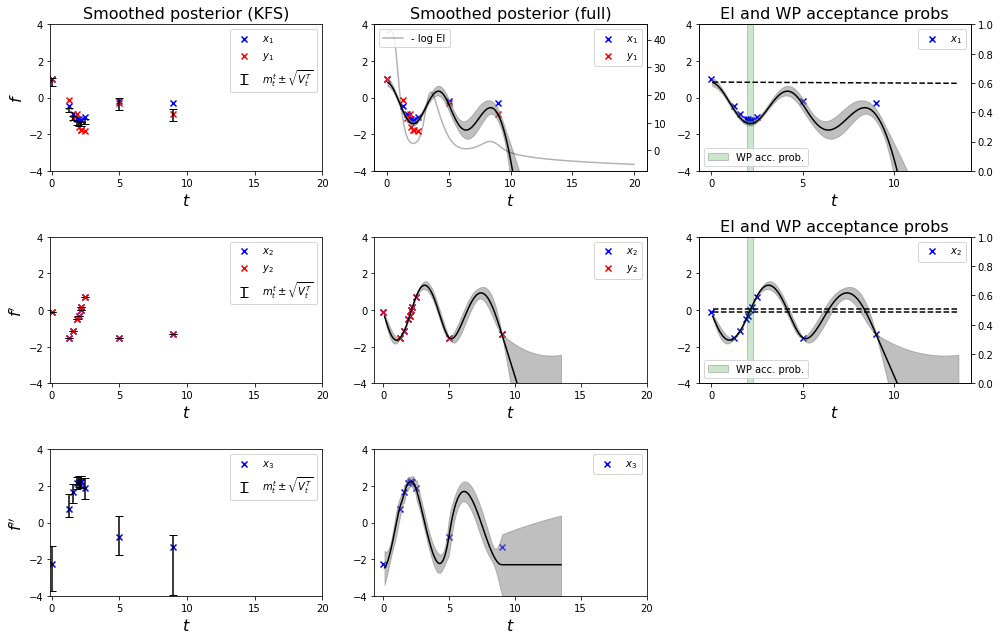

In [13]:
idx = np.argmax(post_probs)

plt.figure(figsize=(14, 9))

t_, m_, v_ = line_post_pred(t, ms[idx], Vs[idx], iVC[idx])

for i in range(3):
    
    # =========================================================================
    # Plotting smoothed posterior
    # =========================================================================
    
    plt.subplot(3, 3, 3 * i + 1)
    
    plt.scatter(t,
                sample_sine_data(t=t, omega=omega, R=0.*R)[0][:, i],
                marker='x',
                color='blue',
                label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (KFS)', fontsize=16)
    
    plt.errorbar(x=t,
                 y=ms[idx][:, i],
                 yerr=Vs[idx][:, i, i] ** 0.5,
                 color='black',
                 zorder=2,
                 fmt="none",
                 label=r"$m_t^t \pm \sqrt{V_t^T}$",
                 capsize=4)
    
    plt.xticks(np.linspace(0, 20, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.xlim([-1e-1, 20])
    plt.ylim([-4, 4])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend(loc='upper right')
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)
    
    # =========================================================================
    # Plotting quintic spline posterior
    # =========================================================================

    plt.subplot(3, 3, 3 * i + 2)
    
    plt.plot(t_, m_[:, i], color='k')
    plt.scatter(t,
                sample_sine_data(t=t, omega=omega, R=0.*R)[0][:, i],
                marker='x',
                color='blue',
                label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        pass
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (full)', fontsize=16)

    plt.fill_between(t_,
                     m_[:, i] - v_[:, i, i] ** 0.5,
                     m_[:, i] + v_[:, i, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.xticks(np.linspace(0, 20, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.ylim([-4, 4])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend(loc='upper right')
    
    if i == 0:
        ax2 = plt.gca().twinx()
        
        mf, Vf, ms__, Vs__, iVC__, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)

        xlin = np.linspace(t[0] + 1e-2, 20 - 1e-2, 200)
        obj = [objective(t=t_, t_data=t, ms=ms__, Vs=Vs__, iVC=iVC__)[0] for t_ in xlin]
        ax2.plot(xlin, obj, color='black', zorder=1, alpha=0.3, label='- log EI')
        
        plt.legend(loc='upper left')
    
    
    # =========================================================================
    # Plotting WP acceptance probabilities
    # =========================================================================

    if i < 2:
        
        plt.subplot(3, 3, 3 * i + 3)

        if i == 0:
            wp_line = ms[idx][0, 0] + t_ * c1 * ms[idx][0, 1]
            plt.plot(t_, wp_line, '--', color='k')
            
        else:
            wp_line1 = c2 * np.abs(ms[idx][0, 1]) * np.ones_like(t_)
            wp_line2 = - c2 * np.abs(ms[idx][0, 1]) * np.ones_like(t_)
            plt.plot(t_, wp_line1, '--', color='k')
            plt.plot(t_, wp_line2, '--', color='k')
        
        plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
        plt.title('EI and WP acceptance probs', fontsize=16)

        plt.plot(t_, m_[:, i], color='k')
        plt.fill_between(t_,
                         m_[:, i] - v_[:, i, i] ** 0.5,
                         m_[:, i] + v_[:, i, i] ** 0.5,
                         color='gray', alpha=0.5)

        plt.xticks(np.linspace(0, 20, 5))
        plt.yticks(np.linspace(-4, 4, 5))
        plt.ylim([-4, 4])

        plt.xlabel(r'$t$', fontsize=16)
        plt.legend(loc='upper right')

        ax2 = plt.gca().twinx()
        ax2.bar(t[1:],
                wp_probs,
                width=0.3,
                color='green',
                alpha=0.2,
                linewidth=1,
                edgecolor='black',
                label='WP acc. prob.')

        plt.legend(loc='lower left')
        plt.ylim([0, 1])

plt.tight_layout()
plt.show()

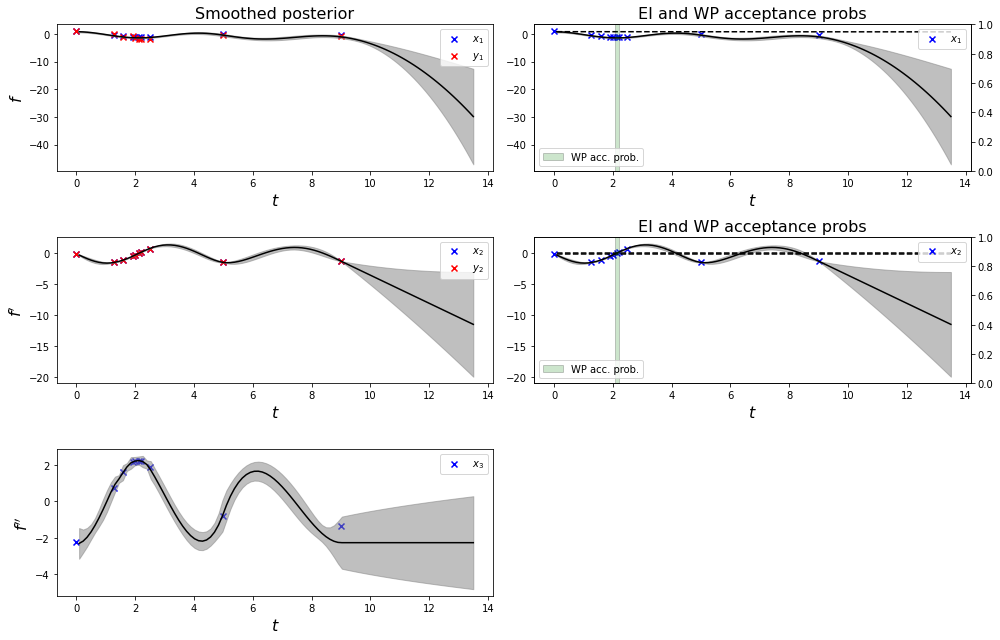

In [14]:
plot_linesearch(c1=c1,
                c2=c2,
                t_data=t,
                ms=ms,
                Vs=Vs,
                iVC=iVC,
                post_probs=post_probs,
                wp_probs=wp_probs,
                x=x,
                y=y)